In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.set_default_device(device)
torch.set_num_threads(1)

In [3]:
train_kwargs = { 'batch_size': 512 }
if use_cuda:
    train_kwargs.update({ 'num_workers': 1, 'pin_memory': True, 'shuffle': True })

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, generator=torch.Generator(device), **train_kwargs)

In [18]:
class ConvVAE(nn.Module):
    def __init__(self, in_channels: int = 1, num_features: int = 32, latent_dim: int = 20):
        super(ConvVAE, self).__init__()
        self.num_features = num_features

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, num_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features),
            nn.LeakyReLU(),
            nn.Conv2d(num_features, num_features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features * 2),
            nn.LeakyReLU(),
            nn.Conv2d(num_features * 2, num_features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features * 4),
            nn.LeakyReLU(),
            nn.Conv2d(num_features * 4, num_features * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features * 8),
            nn.LeakyReLU()
        )

        self.fc_mu = nn.Linear(num_features * 8, latent_dim)
        self.fc_logvar = nn.Linear(num_features * 8, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, num_features * 8 * 2 * 2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(num_features * 8, num_features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features * 4),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(num_features * 4, num_features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features * 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(num_features * 2, num_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(num_features, in_channels, kernel_size=4, stride=2, padding=3),
            nn.Sigmoid()
        )

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        z = self.fc_decode(z)
        z = z.view(z.size(0), self.num_features * 8, 2, 2)
        z = self.decoder(z)
        return z
        
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [19]:
model = ConvVAE(num_features=32, latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [20]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE                                  [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 256, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 32, 14, 14]           544
│    └─BatchNorm2d: 2-2                  [1, 32, 14, 14]           64
│    └─LeakyReLU: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 7, 7]             32,832
│    └─BatchNorm2d: 2-5                  [1, 64, 7, 7]             128
│    └─LeakyReLU: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 3, 3]            131,200
│    └─BatchNorm2d: 2-8                  [1, 128, 3, 3]            256
│    └─LeakyReLU: 2-9                    [1, 128, 3, 3]            --
│    └─Conv2d: 2-10                      [1, 256, 1, 1]            524,544
│    └─BatchNorm2d: 2-11                 [1, 256, 1, 1]            5

In [9]:
def train(model: nn.Module, device: torch.device, train_loader: DataLoader, optimizer: optim.Optimizer, epoch: int):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset)}')

In [10]:
epochs = 100
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

====> Epoch: 1 Average loss: 189.935798828125
====> Epoch: 2 Average loss: 117.47818605143229
====> Epoch: 3 Average loss: 109.52143125
====> Epoch: 4 Average loss: 106.32125721028646
====> Epoch: 5 Average loss: 104.56197454427084
====> Epoch: 6 Average loss: 103.529370703125
====> Epoch: 7 Average loss: 102.62513740234375
====> Epoch: 8 Average loss: 101.98031419270833
====> Epoch: 9 Average loss: 101.3496548828125
====> Epoch: 10 Average loss: 100.77977060546876
====> Epoch: 11 Average loss: 100.5076201171875
====> Epoch: 12 Average loss: 100.25403502604166
====> Epoch: 13 Average loss: 99.61366064453125
====> Epoch: 14 Average loss: 99.45944593098959
====> Epoch: 15 Average loss: 99.13200135091145
====> Epoch: 16 Average loss: 99.103448046875
====> Epoch: 17 Average loss: 98.70156194661459
====> Epoch: 18 Average loss: 98.63004067382812
====> Epoch: 19 Average loss: 98.53777718098958
====> Epoch: 20 Average loss: 98.29655110677083
====> Epoch: 21 Average loss: 98.03034926757813
===

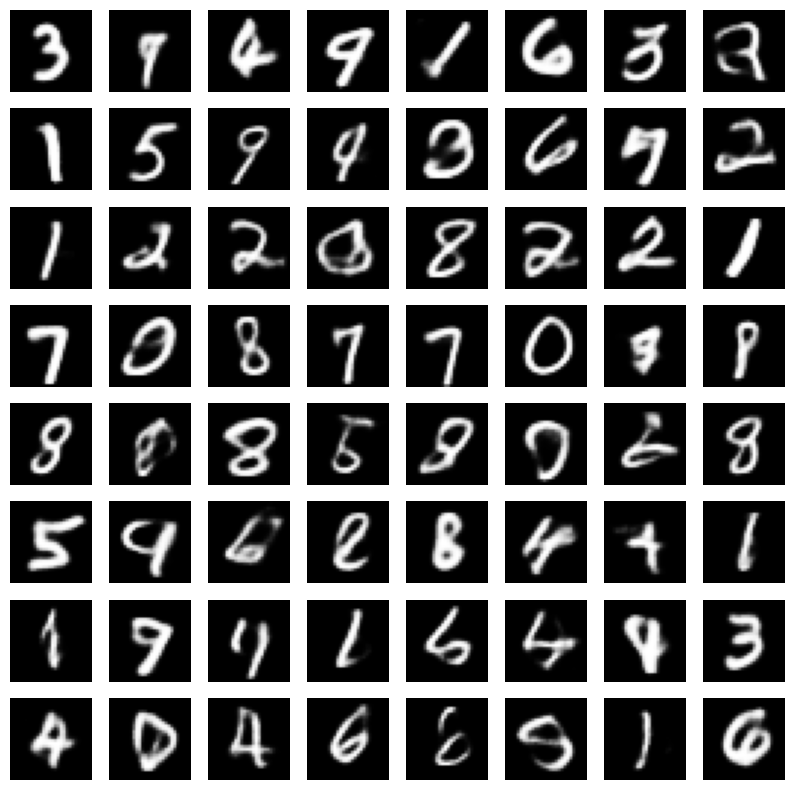

In [11]:
def generate_images(model: ConvVAE, num_images: int = 64, latent_dim: int = 20, device: str = 'cuda'):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        
        # Generate images from the samples
        generated_images = model.decode(z)
        
        # Convert images to numpy for visualization
        generated_images = generated_images.cpu().numpy()
        
        # Rescale images to [0, 1] if necessary (depends on your model's output range)
        generated_images = np.clip(generated_images, 0, 1)
        
        # Reshape for plotting (assuming images are grayscale)
        generated_images = np.transpose(generated_images, (0, 2, 3, 1))  # B, H, W, C
        
        # Plot the generated images
        fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)), figsize=(10, 10))
        for i in range(num_images):
            ax = axes[i // int(np.sqrt(num_images)), i % int(np.sqrt(num_images))]
            ax.imshow(generated_images[i].squeeze(), cmap='gray')
            ax.axis('off')
        plt.show()

generate_images(model, num_images=64, latent_dim=32, device=device)

In [12]:
torch.save(model.state_dict(), './models/conv_vae.pth')